In [1]:
#https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/
# import the required libraries
# github for this: Speech Recognition.ipynb
# https://github.com/aravindpai/Speech-Recognition/blob/master/Speech%20Recognition.ipynb
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

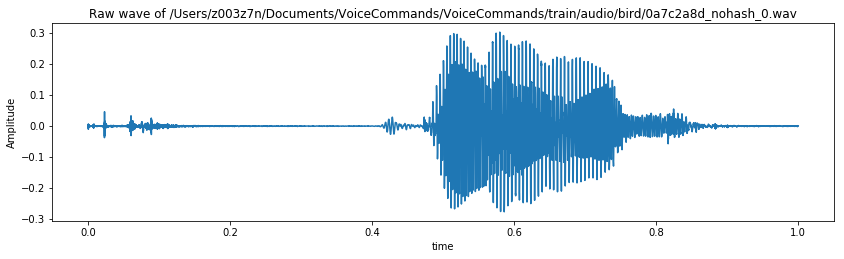

In [2]:
train_audio_path = '/Users/z003z7n/Documents/VoiceCommands/VoiceCommands/train/audio'
samples, sample_rate = librosa.load(train_audio_path+'/bird/0a7c2a8d_nohash_0.wav', sr = 18000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '/Users/z003z7n/Documents/VoiceCommands/VoiceCommands/train/audio/bird/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [3]:
#sampling - Sampling is in Hz here. Low the Hz.. less the clarity. More the Hz, we are observing all the points. So good clarity.

ipd.Audio(samples, rate=sample_rate)


In [4]:
print(samples, sample_rate)

[-0.00017571  0.00108189 -0.00154504 ...  0.00031816  0.00063206
  0.00080767] 18000


In [5]:
# resampling - using resample method in librosa
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

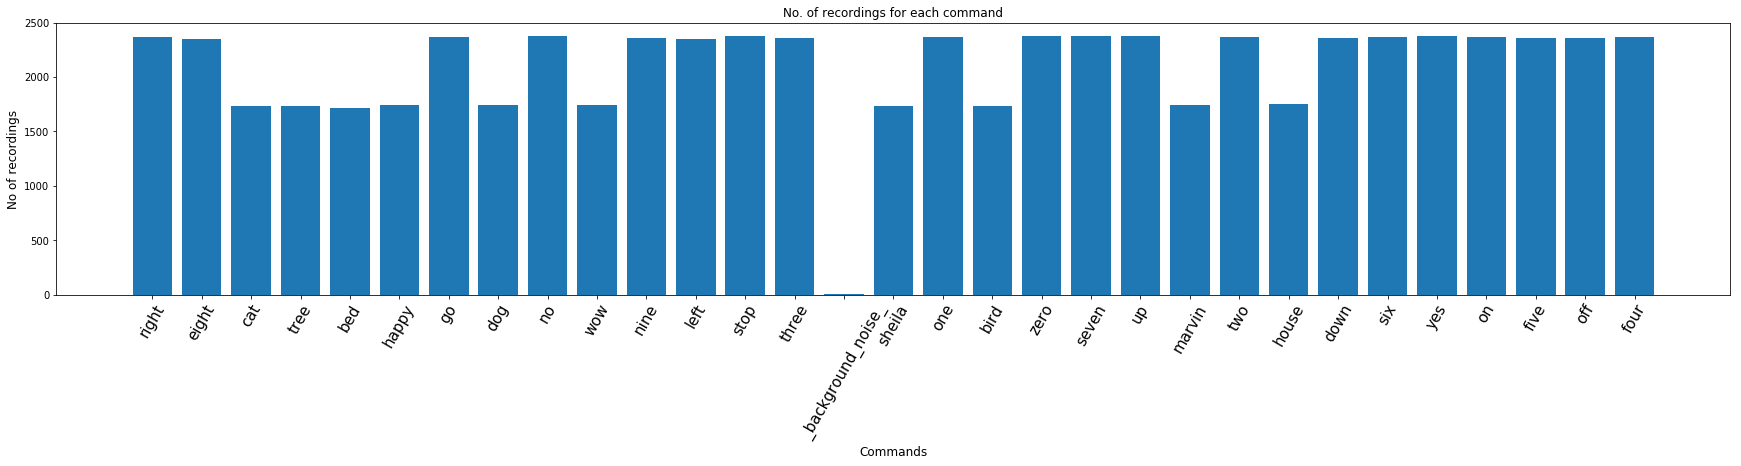

In [6]:
# understanding the training data
labels = os.listdir(train_audio_path)
#labels - will print the list of all the training categories.
no_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path+'/'+label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
#plotting
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

(array([   7.,    8.,   10.,    9.,   34.,   23.,   33.,   35.,   67.,
        2146.]),
 array([0.4586875 , 0.51281875, 0.56695   , 0.62108125, 0.6752125 ,
        0.72934375, 0.783475  , 0.83760625, 0.8917375 , 0.94586875,
        1.        ]),
 <a list of 10 Patch objects>)

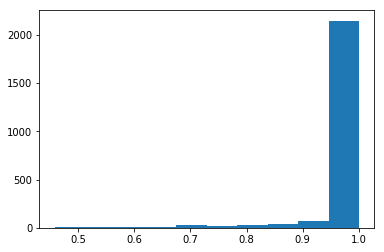

In [7]:
# Duration of recordings

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
duration_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
plt.hist(np.array(duration_of_recordings))

In [8]:
# Resampling as most of the samples are below the 1.0 sec duration. Changing the sample rate = 8000
train_audio_path = '/Users/z003z7n/Documents/VoiceCommands/VoiceCommands/train/audio'
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [ ]:
len(all_label)

2101

In [ ]:
# converting labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le

LabelEncoder()

In [ ]:
y = le.fit_transform(all_label)
classes = list(le.classes_)
classes

['go']

In [ ]:
# converting integer y into a one-hot vector
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
#Reshape the 2D array to 3D since the input to the conv1d must be a 3D array
all_wave = np.array(all_wave).reshape(-1,8000,1)


Using TensorFlow backend.


In [ ]:
y.shape

(2101, 10)

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

We will build the speech-to-text model using conv1d. 
Conv1d is a convolutional neural network which performs the convolution along only one dimension. 

#Model Building

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()
inputs = Input(shape=(8000,1))

In [ ]:
# Running convolutions
#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Flatten layer
conv = Flatten()(conv)
#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)
#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)
outputs = Dense(len(labels), activation='softmax')(conv)
model = Model(inputs, outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxP

In [ ]:
# Defining the loss function
# Define the loss function to be categorical cross-entropy since it is a multi-classification problem

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
#Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
# training on batch size of 32
history=model.fit(x_tr, y_tr ,epochs=1, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Instructions for updating:
Use tf.cast instead.
Train on 1680 samples, validate on 421 samples
Epoch 1/1


In [1]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined